In [3]:
import torch
import time
from snn_delays.snn_refactored import SNN
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.train_utils_refact_minimal import train, get_device, propagate_batch_simple
from snn_delays.utils.test_behavior import tb_minimal

'''
SHD dataset as in ablation study
'''

device = get_device()

# for reproducibility
torch.manual_seed(10)

dataset = 'shd'
total_time = 50
batch_size = 1024

# DATASET
DL = DatasetLoader(dataset=dataset,
                  caching='memory',
                  num_workers=0,
                  batch_size=batch_size,
                  total_time=total_time,
                  crop_to=1e6)
train_loader, test_loader, dataset_dict = DL.get_dataloaders()

num_epochs = 50

lr = 1e-3

Running on: cuda:0
[CropTime(min=0, max=1000000.0), ToFrame(sensor_size=(700, 1, 1), time_window=None, event_count=None, n_time_bins=50, n_event_bins=None, overlap=0, include_incomplete=False)]


In [4]:
structure = (64, 5, 'f')
extra_kwargs = {}

snn = SNN(dataset_dict=dataset_dict, structure=structure, tau_m='normal', win=50, loss_fn='mem_sum', batch_size=batch_size, device=device, 
          **extra_kwargs)

snn.set_layers()
snn.to(device)

snn.save_gradients = True

tau_lr = 0.1

print(snn)
train(snn, train_loader, test_loader, lr, num_epochs, lr_tau=tau_lr, 
      test_behavior=tb_minimal, scheduler=(10, 0.95), test_every=1, gradient_clipping = True)

Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
SNN(
  (criterion): CrossEntropyLoss()
  (layers): ModuleList(
    (0): FeedforwardSNNLayer(
      (linear): Linear(in_features=700, out_features=64, bias=False)
    )
    (1-4): 4 x FeedforwardSNNLayer(
      (linear): Linear(in_features=64, out_features=64, bias=False)
    )
    (5): FeedforwardSNNLayer(
      (linear): Linear(in_features=64, out_features=20, bias=False)
    )
  )
)
Epoch [1/50], learning_rates 0.001000, 0.100000
Step [2/7], Loss: 2.99540
Step [4/7], Loss: 2.98485
Step [6/7], Loss: 2.97056
Step [8/7], Loss: 2.96938
8156
Time elasped: 37.191070318222046
Gradient norms: {'layers.0.tau_m': 0.0, 'layers.0.linear.weight': 0.0, 'layers.1.tau_m': 0.0, 'layers.1.linear.weight': 0.0, 'layers.2.tau_m': 0.0, 'layers.2.linear.weight': 0.0, 'layers.3.tau_m': 0.0, 'layers.3.linear.weight': 0.0, 'layers.4.tau_m': 0.0, 'layers.4.linear.weight': 0.02, 'layers.5.tau_m': 0.0, 'layers.5

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from matplotlib.ticker import MaxNLocator, FuncFormatter

def plot_gradient_evolution(gradient_history, param_type='linear'):
    # Prepare data structure: {layer_name: [epoch0_norm, epoch1_norm, ...]}
    layer_evolution = defaultdict(list)
    epochs = []
    
    for epoch, grad_dict in gradient_history:
        epochs.append(epoch)
        for layer, norm in grad_dict.items():
            if param_type in layer:
                clean_name = layer.replace('layers.', 'Layer ').replace('linear', '').replace('.', ' ')
                layer_evolution[clean_name].append(norm)

    # Create plot
    #plt.figure(figsize=(12, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(layer_evolution)))
   
    for (layer, norms), color in zip(layer_evolution.items(), colors):
        plt.plot(epochs, norms, 
                label=layer, 
                color=color,
                linewidth=2,
                marker='o',
                markersize=4,
                alpha=0.8)
        
    # Styling
    plt.title('Gradient Norm Evolution by Layer', fontsize=14, pad=20)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Gradient Norm (L2)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    print(layer_evolution.values())

    # Dynamic y-axis scaling
    max_norm = float(max([max(norms) for norms in layer_evolution.values()]))
    print(max_norm)
    plt.ylim(0, max_norm*1.1)

    plt.tight_layout()
    return plt.gca()

## Feedforward

dict_values([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.01, 0.0, 0.01, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.01, 0.0], [0.0, 0.0, 0.0, 0.01, 0.0, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.01, 0.02, 0.01, 0.01, 0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.01, 0.02, 0.01, 0.02, 0.01, 0.01, 0.02, 0.01, 0.02, 0.01, 0.02, 0.01], [0.0, 0.01, 0.01, 0.02, 0.02, 0.04, 0.05, 0.04, 0.04, 0.05, 0.03, 0.03, 0.05, 0.04, 0.03, 0.04, 0.06, 0.03, 0.02, 0.04, 0.03, 0.03, 0.04, 0.03, 0.04, 0.05, 0.04, 0.04, 0.04, 0.03

<Axes: title={'center': 'Gradient Norm Evolution by Layer'}, xlabel='Epoch', ylabel='Gradient Norm (L2)'>

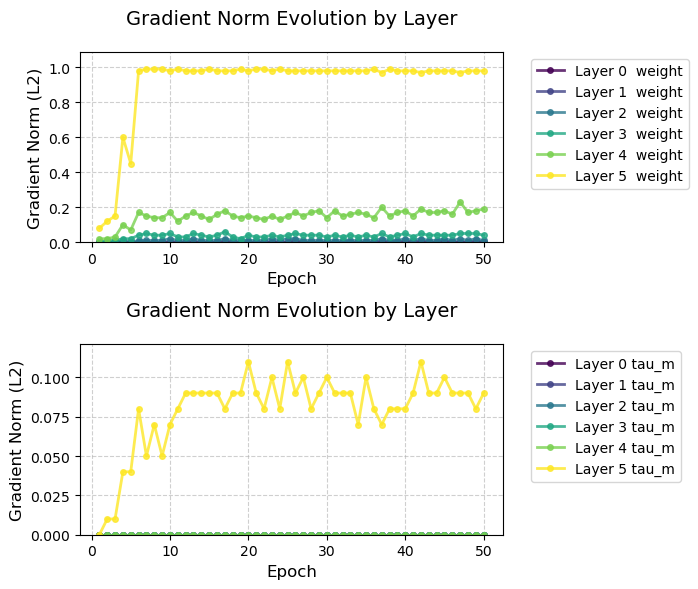

In [6]:
plt.figure(figsize=(7, 6))
plt.subplot(211)
plot_gradient_evolution(snn.test_gradients, 'linear.')
plt.subplot(212)
plot_gradient_evolution(snn.test_gradients, 'tau_m')

In [7]:
structure = (64, 5, 'r')
extra_kwargs = {}

snn = SNN(dataset_dict=dataset_dict, structure=structure, tau_m='normal', win=50, loss_fn='mem_sum', batch_size=batch_size, device=device, 
          **extra_kwargs)

snn.set_layers()
snn.to(device)

snn.save_gradients = True

tau_lr = 0.1

print(snn)
train(snn, train_loader, test_loader, lr, num_epochs, lr_tau=tau_lr, 
      test_behavior=tb_minimal, scheduler=(10, 0.95), test_every=1, gradient_clipping = True)

Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
SNN(
  (criterion): CrossEntropyLoss()
  (layers): ModuleList(
    (0): RecurrentSNNLayer(
      (linear): Linear(in_features=700, out_features=64, bias=False)
      (linear_rec): Linear(in_features=64, out_features=64, bias=False)
    )
    (1-4): 4 x RecurrentSNNLayer(
      (linear): Linear(in_features=64, out_features=64, bias=False)
      (linear_rec): Linear(in_features=64, out_features=64, bias=False)
    )
    (5): FeedforwardSNNLayer(
      (linear): Linear(in_features=64, out_features=20, bias=False)
    )
  )
)
Epoch [1/50], learning_rates 0.001000, 0.100000
Step [2/7], Loss: 3.17268
Step [4/7], Loss: 3.04331
Step [6/7], Loss: 3.01483
Step [8/7], Loss: 3.02099
8156
Time elasped: 3.4801578521728516
Gradient norms: {'layers.0.tau_m': 0.0, 'layers.0.linear.weight': 0.0, 'layers.0.linear_rec.weight': 0.0, 'layers.1.tau_m': 0.0, 'layers.1.linear.weight': 0.0, 'layers.1.linear_rec

In [8]:
snn.test_gradients

[[1,
  {'layers.0.tau_m': 0.0,
   'layers.0.linear.weight': 0.0,
   'layers.0.linear_rec.weight': 0.0,
   'layers.1.tau_m': 0.0,
   'layers.1.linear.weight': 0.0,
   'layers.1.linear_rec.weight': 0.0,
   'layers.2.tau_m': 0.0,
   'layers.2.linear.weight': 0.0,
   'layers.2.linear_rec.weight': 0.0,
   'layers.3.tau_m': 0.0,
   'layers.3.linear.weight': 0.01,
   'layers.3.linear_rec.weight': 0.01,
   'layers.4.tau_m': 0.0,
   'layers.4.linear.weight': 0.06,
   'layers.4.linear_rec.weight': 0.06,
   'layers.5.tau_m': 0.01,
   'layers.5.linear.weight': 0.56}],
 [2,
  {'layers.0.tau_m': 0.0,
   'layers.0.linear.weight': 0.0,
   'layers.0.linear_rec.weight': 0.0,
   'layers.1.tau_m': 0.0,
   'layers.1.linear.weight': 0.0,
   'layers.1.linear_rec.weight': 0.0,
   'layers.2.tau_m': 0.0,
   'layers.2.linear.weight': 0.0,
   'layers.2.linear_rec.weight': 0.0,
   'layers.3.tau_m': 0.0,
   'layers.3.linear.weight': 0.0,
   'layers.3.linear_rec.weight': 0.0,
   'layers.4.tau_m': 0.0,
   'layers.4.l

## Recurrent

dict_values([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.01, 0.0, 0.0, 0.0, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,

<Axes: title={'center': 'Gradient Norm Evolution by Layer'}, xlabel='Epoch', ylabel='Gradient Norm (L2)'>

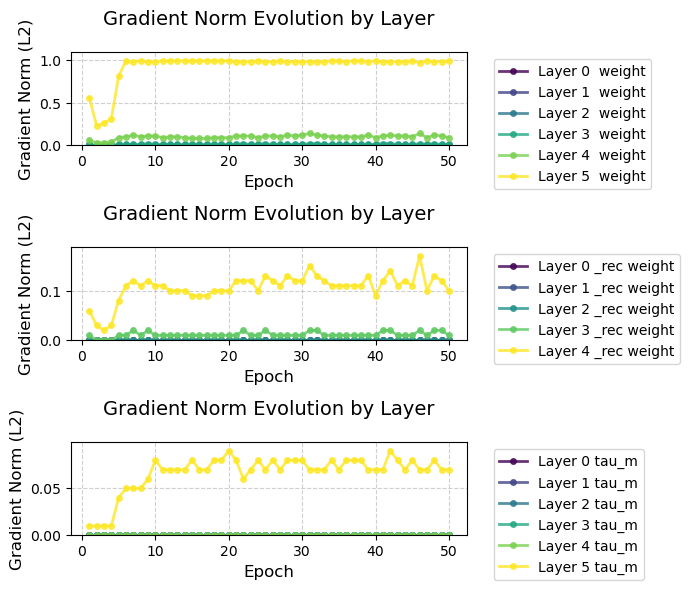

In [9]:
plt.figure(figsize=(7, 6))
plt.subplot(311)
plot_gradient_evolution(snn.test_gradients, 'linear.')
plt.subplot(312)
plot_gradient_evolution(snn.test_gradients, 'rec')
plt.subplot(313)
plot_gradient_evolution(snn.test_gradients, 'tau_m')

In [10]:
structure = (64, 5, 'd')
extra_kwargs = {'delay_range':(40, 1),
                'pruned_delays': 3}


snn = SNN(dataset_dict=dataset_dict, structure=structure, tau_m='normal', win=50, loss_fn='mem_sum', batch_size=batch_size, device=device, 
          **extra_kwargs)

snn.save_gradients = True

snn.set_layers()
snn.to(device)
print(snn)
train(snn, train_loader, test_loader, lr, num_epochs, lr_tau=tau_lr, 
      test_behavior=tb_minimal, scheduler=(10, 0.95), test_every=1, gradient_clipping = True)

Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
Delta t: 20.0 ms
SNN(
  (criterion): CrossEntropyLoss()
  (layers): ModuleList(
    (0): FeedforwardSNNLayer(
      (linear): Linear(in_features=700, out_features=64, bias=False)
    )
    (1-3): 3 x FeedforwardSNNLayer(
      (linear): Linear(in_features=64, out_features=64, bias=False)
    )
    (4): FeedforwardSNNLayer(
      (linear): Linear(in_features=2560, out_features=64, bias=False)
    )
    (5): FeedforwardSNNLayer(
      (linear): Linear(in_features=64, out_features=20, bias=False)
    )
  )
)
Epoch [1/50], learning_rates 0.001000, 0.100000
Step [2/7], Loss: 2.99326
Step [4/7], Loss: 2.97508
Step [6/7], Loss: 2.94378
Step [8/7], Loss: 2.88400
8156
Time elasped: 4.057823896408081
Gradient norms: {'layers.0.tau_m': 0.0, 'layers.0.linear.weight': 0.0, 'layers.1.tau_m': 0.0, 'layers.1.linear.weight': 0.0, 'laye

## Delays

dict_values([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.01, 0.0, 0.0, 0.01, 0.01, 0.01, 0.01, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.01, 0.01, 0.0, 0.0, 0.01, 0.01, 0.01, 0.0, 0.01, 0.0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.01, 0.0, 0.0], [0.01, 0.03, 0.04, 0.04, 0.02, 0.03, 0.03, 0.03, 0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.03, 0.02, 0.02, 0.03, 0.02, 0.02, 0.02, 0.02, 0.03, 0.03, 0.02, 0.01, 0.02, 0.03, 0.02, 0.02, 0.02, 0.02, 0.02,

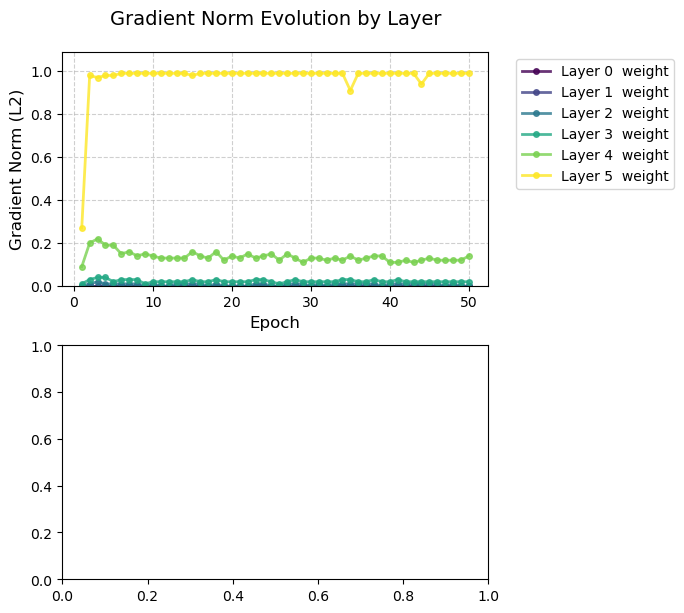

In [11]:
plt.figure(figsize=(7, 6))
plt.subplot(211)
plot_gradient_evolution(snn.test_gradients)
plt.subplot(212)
train(snn, train_loader, test_loader, lr, num_epochs, lr_tau=tau_lr, 
      test_behavior=tb_minimal, scheduler=(10, 0.95), test_every=1, gradient_clipping = True)